In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, Bidirectional, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
#from tensorflow.keras.optimizers import legacy
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import io
import numpy as np

df2 = pd.read_excel('UpdatedDataSet.xlsx')
#df.head()
def pauta_criterion(series, threshold=3):
    """
    Identifies outliers in a series using the Pauta criterion (3-sigma rule).
    Returns a boolean mask to keep non-outliers.
    """
    mean = series.mean()
    std_dev = series.std()
    outliers = (series - mean).abs() > threshold * std_dev
    return ~outliers  # Invert mask to keep non-outliers

# Filter data to exclude outliers based on Pauta criterion
non_outliers_mask = pauta_criterion(df2['Target'])  # Apply only to 'Target' column
df_filtered = df2[non_outliers_mask]

df=df_filtered

df1= df [(df['Target'] > 0)]
df1.head()
y = df.Target - min(df.Target) +1

In [4]:
y= np.log1p(y)
x = df.drop("Target", axis =1)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)

In [6]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
#x_train.head()

(55470, 75)
(55470,)
(13868, 75)
(13868,)


In [7]:
epoch = 20
batch_size = 64
steps_per_epoch = len(x_train) // batch_size
cyclic_lr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-04,
                                                maximal_learning_rate=1e-02,
                                                scale_fn=lambda x: 1/(2**(x-1)),
                                                step_size=6 * steps_per_epoch)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
optimizer = Adam(learning_rate=cyclic_lr, amsgrad=True)
def base_model_lstm():

    model = Sequential()
    model.add(LSTM(units = 128, return_sequences = True, activation="relu", input_shape = (75, 1),  recurrent_dropout=0.2, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    return model

lstm_model = base_model_lstm()
lstm_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 75, 128)           66560     
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 128)               1228928   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,295,617
Trainable params: 1,295,617
Non-trainable params: 0
_________________________________________________________________


2024-11-13 14:11:53.805341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-13 14:11:53.805385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-11-13 14:11:53.805421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-11-13 14:11:53.805451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-11-13 14:11:53.833252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)
history = lstm_model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs =epoch,
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/20
759/759 [==============================] - 33s 42ms/step - loss: 0.7501 - val_loss: 0.1557
Epoch 2/20
759/759 [==============================] - 32s 42ms/step - loss: 0.2238 - val_loss: 0.0808
Epoch 3/20
759/759 [==============================] - 32s 42ms/step - loss: 0.1960 - val_loss: 0.1921
Epoch 4/20
759/759 [==============================] - 32s 42ms/step - loss: 0.1825 - val_loss: 0.0629
Epoch 5/20
759/759 [==============================] - 32s 42ms/step - loss: 0.1718 - val_loss: 0.1619
Epoch 6/20
759/759 [==============================] - 32s 42ms/step - loss: 0.1518 - val_loss: 0.1008
Epoch 7/20
759/759 [==============================] - 32s 42ms/step - loss: 0.1275 - val_loss: 0.0569
Epoch 8/20
759/759 [==============================] - 32s 42ms/step - loss: 0.1038 - val_loss: 0.0457
Epoch 9/20
759/759 [==============================] - 32s 42ms/step - loss: 0.0878 - val_loss: 0.0450
Epoch 10/20
759/759 [==============================] - 32s 42ms/step - loss: 0.077

In [9]:
y_predict = lstm_model.predict(x_test)

#y_predict = y_predict.transpose()
y_predict = y_predict.flatten()
print(y_predict)
diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_predict})
print(diff)


[5.168249  5.2228966 5.1649036 ... 5.1572666 5.1993694 5.383492 ]
       Actual value  Predicted value
5880       5.160778         5.168249
13915      5.208064         5.222897
10350      4.830312         5.164904
4608       5.167981         5.148251
63338      5.193956         5.185721
...             ...              ...
33851      5.196949         5.227066
3507       5.160606         5.138942
7543       5.187498         5.157267
30921      5.208447         5.199369
33891      5.493802         5.383492

[13868 rows x 2 columns]


In [10]:
def MAPE(Y_actual, Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted  ) / Y_actual)) * 100
    return mape


meanAbErr = metrics.mean_absolute_error(y_test, y_predict)
meanSqErr = metrics.mean_squared_error(y_test, y_predict)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_predict))
mape= MAPE(y_test,y_predict)
#print('R squared: {:.2f}'.format(regr.score(x,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Absolute percentage Error:', mape)
#print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

Mean Absolute Error: 0.0384117139805791
Mean Absolute percentage Error: 0.7179330091441234
Root Mean Square Error: 0.07208240911965029


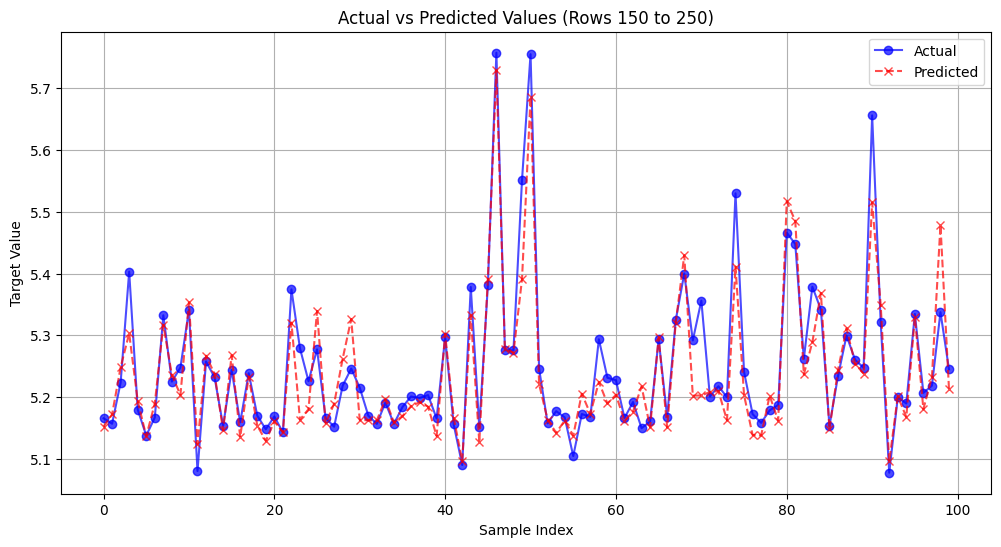

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `y_test` is the actual target values and `y_predict` are the predicted values from the LSTM model

# Flatten y_predict if it's a multi-dimensional array
y_predict = y_predict.flatten()

# Plot actual vs predicted values for rows 150 to 250
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[150:250], label="Actual", marker='o', linestyle='-', color='blue', alpha=0.7)
plt.plot(y_predict[150:250], label="Predicted", marker='x', linestyle='--', color='red', alpha=0.7)
plt.title("Actual vs Predicted Values (Rows 150 to 250)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
meanAbErr = metrics.mean_absolute_error(y_test, y_predict)
meanSqErr = metrics.mean_squared_error(y_test, y_predict)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_predict))
mape= MAPE(y_test,y_predict)
#print('R squared: {:.2f}'.format(regr.score(x,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Absolute percentage Error:', mape)
#print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

Mean Absolute Error: 0.0384117139805791
Mean Absolute percentage Error: 0.7179330091441234
Root Mean Square Error: 0.07208240911965029
